#### Prerequesites:
* Define schema (make figure) 
* Define structure (make figure)
* Define schema class in python (src/models/model_schemata.py)
* Convert schema + structure into model template (models/templates/p_model.pl)

#### Procedure:
* Load data
* Create lfi script
* Add uncertain evidence to lfi model as probabilistic clauses

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importing libraries
import pandas as pd
import os

from src.models import model_schemata as schema
from src.models import build_model as build
from src.data import prep_data as prep

In [5]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

In [8]:
es_interaction_op = pd.read_csv('data/processed/ebdt_data/es_interaction_tp.csv')
es_interaction_c = pd.read_csv('data/processed/ebdt_data/es_interaction_cantley_tp.csv')
e_function = pd.read_csv('data/processed/ebdt_data/e_function.csv')
p_fc = pd.read_csv('data/processed/ebdt_data/p_fc_scaled_HL60_tp.csv')
e_ksea = pd.read_csv('data/processed/ebdt_data/e_ksea_c_penalised_HL60.csv')

In [9]:
es_interaction_c = es_interaction_c.loc[es_interaction_c['percentile'] > 0.995]
es_interaction_c

,enzyme,substrate,percentile
152,AAK1,POM121C(T375),0.9962
418,AAK1,TRAFD1(T323),0.9961
561,AAK1,GIPC1(T238),0.9968
581,AAK1,PPP1R12A(T443),0.9995
694,AAK1,CHUK(T23),0.9987
...,...,...,...
5337626,ZAK,GIT1(S546),0.9956
5337654,ZAK,NOP16(S16),0.9985
5337767,ZAK,CEP170B(S492),0.9952
5337793,ZAK,IRS2(S30),0.9999


In [10]:
# merge es_interaction and es_interaction_c on enzyme and substrate
es_interaction = es_interaction_op.merge(es_interaction_c, on=['enzyme', 'substrate'], how='outer')
es_interaction.fillna(1, inplace=True)
es_interaction

,enzyme,substrate,percentile
0,ABL1,ABI1(Y213),1.0000
1,ABL1,ABL1(S919),1.0000
2,ABL1,ABL1(Y226),1.0000
3,ABL1,ABL1(Y393),1.0000
4,ABL1,AHSA1(Y223),1.0000
...,...,...,...
101828,ZAK,GIT1(S546),0.9956
101829,ZAK,NOP16(S16),0.9985
101830,ZAK,CEP170B(S492),0.9952
101831,ZAK,IRS2(S30),0.9999


In [11]:
# Filtering
# remove interactions where the kpa is not in the phosphoproteomics data
es_interaction = es_interaction[es_interaction['substrate'].isin(p_fc['phosphosite'])]
es_interaction = es_interaction[es_interaction['enzyme'].isin(e_ksea['enzyme'])]
# select fold change data for psts which are in interaction data
p_fc = p_fc[p_fc['phosphosite'].isin(es_interaction['substrate'])]
e_ksea = e_ksea[e_ksea['enzyme'].isin(es_interaction['enzyme'])]
# select enzyme function data for enzymes which are in interaction data
e_function = e_function[e_function['enzyme'].isin(es_interaction['enzyme'])]
# define all pst which are in fold change data or interaction data and store in data frame
phosphosites = list(set(p_fc['phosphosite'].tolist()))
# define all enzymes which are in activity, interaction or enz_class data and store in data frame
enzymes = list(set(es_interaction['enzyme'].tolist()))

In [12]:
es_interaction

,enzyme,substrate,percentile
0,ABL1,ABI1(Y213),1.0000
15,ABL1,CDK5(Y15),1.0000
18,ABL1,CRKL(Y207),1.0000
22,ABL1,DGCR8(Y267),1.0000
50,ABL1,PIK3AP1(Y570),1.0000
...,...,...,...
101796,ZAK,KIF2C(S187),0.9999
101801,ZAK,HIRIP3(S27),0.9974
101808,ZAK,CCDC8(S273),0.9996
101829,ZAK,NOP16(S16),0.9985


In [14]:
len(phosphosites)

4828

<Axes: ylabel='Frequency'>

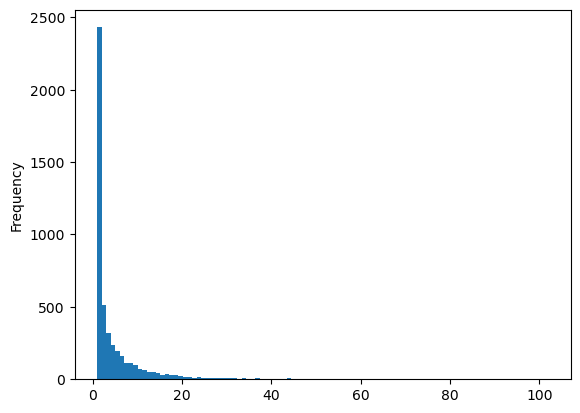

In [15]:
# plot histogram of number of interactions per phosphosite
es_interaction['substrate'].value_counts().plot(kind='hist', bins=100)

In [16]:
# Create pandas DataFrames
interactions = es_interaction.loc[es_interaction['substrate'].isin(es_interaction['substrate'].value_counts()[es_interaction['substrate'].value_counts() >= 7].index)].reset_index(drop=True)
subs = p_fc.loc[p_fc['phosphosite'].isin(interactions['substrate'])].reset_index(drop=True)
enz = e_ksea.loc[e_ksea['enzyme'].isin(interactions['enzyme'])].reset_index(drop=True)

substrate_correlations, sorted_enzyme_correlations = prep.extract_top_corr_enzymes(subs, enz, interactions, max_enzymes=7, min_corr=0)

# Filter the interactions based on substrate_correlations
filtered_interactions = prep.filter_interactions_by_correlations(es_interaction, substrate_correlations)

<Axes: ylabel='Frequency'>

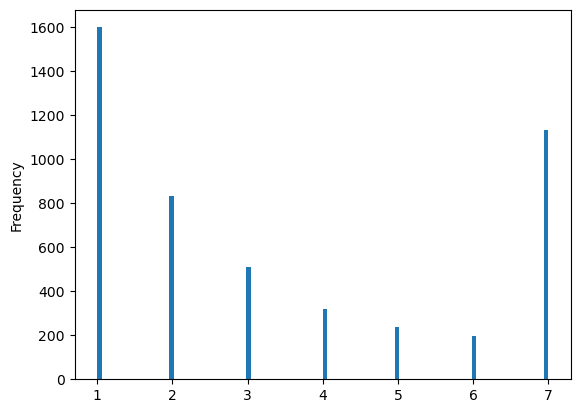

In [17]:
filtered_interactions.substrate.value_counts().plot(kind='hist', bins=100)

In [18]:
test = es_interaction_op.merge(filtered_interactions, on=['enzyme', 'substrate'], how='inner')
test

,enzyme,substrate,percentile
0,ABL1,ABI1(Y213),1.0
1,ABL1,CDK5(Y15),1.0
2,ABL1,CRKL(Y207),1.0
3,ABL1,DGCR8(Y267),1.0
4,ABL1,PIK3AP1(Y570),1.0
...,...,...,...
2227,VRK3,YWHAQ(S232),1.0
2228,WEE1,CDK2(Y15),1.0
2229,WEE1,WEE1(T173),1.0
2230,WNK1,STK39(S371),1.0


In [19]:
len(filtered_interactions)

16368

In [14]:
e_ksea = e_ksea[e_ksea['enzyme'].isin(filtered_interactions['enzyme'])]
e_function = e_function[e_function['enzyme'].isin(filtered_interactions['enzyme'])]

In [15]:
# Mapping data to Problog predicates
predicates = {}
predicates['enzyme'] = schema.EnzymePredicate(enzyme_list=enzymes)
predicates['phosphosite'] = schema.PhosphositePredicate(phosphosite_list=phosphosites)
predicates['es_interaction'] = schema.ESInteractionPredicate(dataframe=filtered_interactions, enzyme_col='enzyme', phosphosite_col='substrate')
predicates['e_function'] = schema.EFunctionPredicate(dataframe=e_function, enzyme_col='enzyme', function_col='function')

# Adding entites, relationships, and fixed attributes to template model
model_skeleton = 'models/ebdt_data/p_model/p_model_lfi_run7.pl'

for predicate in predicates:
    fact_generator = build.ProblogStatementGenerator(predicates[predicate])
    problog_facts = fact_generator.generate_facts(build.FactTemplate) # generate Problog facts
    build.insert_statements(model=model_skeleton, statements=problog_facts, location='%% {}'.format(predicate)) # insert into Problog file

In [16]:
e_ksea_ad = prep.expand_ad_cpd(e_ksea, 'value')
p_fc_ad = prep.expand_ad_cpd(p_fc, 'value')
p_fc_ad

,phosphosite,sample,value,prob,p_dec,p_inc,p_base
0,AAGAB(S310),AC220,dec,0.779575,0.779575,0.001000,0.219425
1,AAGAB(S310),AC220,inc,0.779575,0.001000,0.779575,0.219425
2,AAGAB(S310),AT13148,dec,0.899580,0.899580,0.001000,0.099420
3,AAGAB(S310),AT13148,inc,0.899580,0.001000,0.899580,0.099420
4,AAGAB(S310),AZ20,dec,0.899580,0.899580,0.001000,0.099420
...,...,...,...,...,...,...,...
589011,ZZEF1(S1518),U73122,inc,0.544940,0.001000,0.544940,0.454060
589012,ZZEF1(S1518),Ulixertinib,dec,0.683004,0.683004,0.001000,0.315996
589013,ZZEF1(S1518),Ulixertinib,inc,0.683004,0.001000,0.683004,0.315996
589014,ZZEF1(S1518),Vemurafenib,dec,0.464671,0.464671,0.001000,0.534329


In [17]:
# Mapping data to Problog predicates
# make sure to delete 'base' from schemata and AnnotatedDisjunctionClauseTemplate
predicates = {}
predicates['e_ksea'] = schema.EKseaPredicate()
predicates['e_ksea'].add_data(e_ksea_ad, 'enzyme', 'sample', 'value')
predicates['e_ksea'].add_ad_probabilities(e_ksea_ad, p_dec_col='p_dec', p_base_col='p_base', p_inc_col='p_inc')
predicates['p_fc'] = schema.PFoldChangePredicate()
predicates['p_fc'].add_data(p_fc_ad, 'phosphosite', 'sample', 'value')
predicates['p_fc'].add_ad_probabilities(p_fc_ad, p_dec_col='p_dec', p_base_col='p_base', p_inc_col='p_inc')

In [21]:
model_lfi = 'models/ebdt_data/p_model/p_model_lfi_run7.pl'
for predicate in predicates: 
    ad_generator = build.ProblogStatementGenerator(predicates[predicate])
    clauses = ad_generator.generate_ad_clauses(type='boolean')
    clauses.extend(ad_generator.generate_ad_clauses(type='domain'))
    build.insert_statements(model=model_lfi, statements=clauses, location='%% p1::{}'.format(predicate)) # insert into Problog file

In [22]:
filtered_interactions.to_csv('data/processed/ebdt_data/run7/es_interaction_top7enz.csv', index=False)
p_fc.to_csv('data/processed/ebdt_data/run7/p_fc.csv', index=False)
e_ksea.to_csv('data/processed/ebdt_data/run7/e_ksea.csv', index=False)
e_function.to_csv('data/processed/ebdt_data/run7/e_function.csv', index=False)